# Big Data in Finance: In-Class Presentation

In [4]:
import time
import pandas as pd
import datetime as dt
import helper_functs as hf
import warnings
import copy
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Loading Dataset

In [5]:
tickers = pd.read_excel("data_sources/PERMNO_Tickers.xlsx", index_col="Dates")
tickers.index = pd.to_datetime(tickers.index,  format='%Y%m%d').date
tickers.name = "TICKERS"

flows = pd.read_excel("data_sources/Flows_Clean.xlsx", index_col="Dates")
flows.index = pd.to_datetime(flows.index, format='%Y%m%d').date
flows.name = "FLOWS"

returns = pd.read_excel("data_sources/Returns_Clean.xlsx", index_col="Dates")
returns.index = pd.to_datetime(returns.index,format='%Y%m%d').date
returns.name = "RETURNS"

# Warm-Up

In [6]:
PERMNO = list(returns.columns) #PERMNO is the same everywhere, i.e. tickers, flows, returns
WINDOW_SIZE = 50

### Rolling MA Benchmark

In [26]:
all_stocks =pd.DataFrame(index=returns.index)
all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"] = 0
SMA_cumulative_RMSE_per_stock= {}
for number in PERMNO:
    stock = hf.create_stock_df(number,[flows, returns,tickers])
    stock_lagged = hf.get_lags(stock, 3).dropna()
    stock_X, stock_Y = hf.x_y_split(stock_lagged)
    stock_SMA = copy.deepcopy(stock_Y)
    stock_SMA.columns = [f'{number}_RETURNS' if x=='RETURNS' else x for x in stock_SMA.columns]
    stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_PRED"]=stock_SMA[f'{number}_RETURNS'].rolling(WINDOW_SIZE).mean().shift(1)
    stock_SMA = stock_SMA.dropna()    
    stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_SQD_FORECAST_ERROR"]=(stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_PRED"]-stock_SMA[f'{number}_RETURNS'])**2
    stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_RMSE"] = stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
    all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"] += stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_RMSE"]
    SMA_cumulative_RMSE_per_stock[number]= stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_RMSE"].sum()
    all_stocks[stock_SMA.columns]= stock_SMA

1.0550079345703125


<AxesSubplot:>

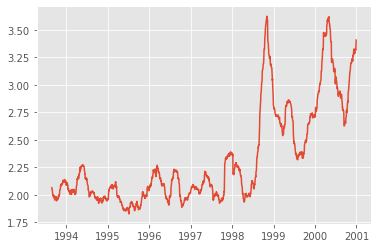

In [25]:
all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"].plot()

### Rolling Regression

In [ ]:
all_stocks[f"LM_{WINDOW_SIZE}_CUM_RMSE"] = 0
start = time.time()
for i,number in enumerate(PERMNO):
    stock = hf.create_stock_df(number,[flows, returns, tickers])
    x_small = hf.get_lags(stock, 3).dropna()
    x_full = hf.extend_variables(number, x_small, returns, flows)
    stock_LM = hf.Rolling_ML(WINDOW_SIZE, x_full, linear_model.LinearRegression(),progession_param=0.2)
    stock_LM.columns = [f'{number}_{WINDOW_SIZE}_LM_{x}' for x in stock_LM.columns]
    stock_LM[f"{number}_{WINDOW_SIZE}_LM_SQD_FORECAST_ERROR"] = (stock_LM[f"{number}_{WINDOW_SIZE}_LM_PRED"]-stock_LM[f'{number}_{WINDOW_SIZE}_LM_RETURNS'])**2
    stock_LM[f"{number}_{WINDOW_SIZE}_LM_RMSE"] = stock_LM[f"{number}_{WINDOW_SIZE}_LM_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
    all_stocks[f"LM_{WINDOW_SIZE}_CUM_RMSE"] += stock_LM[f"{number}_{WINDOW_SIZE}_LM_RMSE"]
    all_stocks[stock_LM.columns]= stock_LM
    end = time.time()
    if (i+1) % 10 == 0:
        print(f"{i+1}/{100}",f"{end-start} seconds have passed")

5/100 63.15019488334656 seconds have passed
10/100 135.09204077720642 seconds have passed
15/100 221.69780087471008 seconds have passed
20/100 299.8179488182068 seconds have passed
25/100 373.19858288764954 seconds have passed
30/100 449.2764480113983 seconds have passed
35/100 521.6154079437256 seconds have passed
40/100 581.4980940818787 seconds have passed
45/100 647.1760559082031 seconds have passed
50/100 714.2795259952545 seconds have passed
55/100 783.780767917633 seconds have passed


<AxesSubplot:>

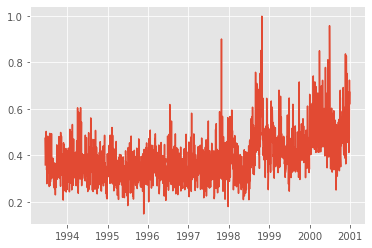

In [10]:
all_stocks[f"LM_{WINDOW_SIZE}_CUM_RMSE"].plot()

### Rolling LASSO

In [11]:
hyperparameters_LASSO = {'alpha': [1,0.1, 0.01]}

In [12]:
all_stocks[f"LASSO_{WINDOW_SIZE}_CUM_RMSE"] = 0
start = time.time()
for i,number in enumerate(PERMNO):
    stock = hf.create_stock_df(number,[flows, returns, tickers])
    x_small = hf.get_lags(stock, 3).dropna()
    x_full = hf.extend_variables(number, x_small, returns, flows)
    stock_LASSO = hf.Rolling_ML(WINDOW_SIZE, x_full, linear_model.Lasso(alpha=0.01),progession_param=0.2)
    stock_LASSO.columns = [f'{number}_{WINDOW_SIZE}_LASSO_{x}' for x in stock_LASSO.columns]
    stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_SQD_FORECAST_ERROR"] = (stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_PRED"]-stock_LASSO[f'{number}_{WINDOW_SIZE}_LASSO_RETURNS'])**2
    stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_RMSE"] = stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE)**0.5
    all_stocks[f"LASSO_{WINDOW_SIZE}_CUM_RMSE"] += stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_RMSE"]
    all_stocks[stock_LASSO.columns]= stock_LASSO
    end = time.time()
    if (i+1) % 10 == 0:
        print(f"{i+1}/{100}",f"{end-start} seconds have passed")

5/100 57.31531596183777 seconds have passed
10/100 108.2594199180603 seconds have passed
15/100 162.54185605049133 seconds have passed
20/100 224.57354187965393 seconds have passed
25/100 285.03382301330566 seconds have passed
30/100 348.23546981811523 seconds have passed
35/100 414.11819195747375 seconds have passed
40/100 471.4963138103485 seconds have passed
45/100 530.7550568580627 seconds have passed
50/100 594.1034178733826 seconds have passed
55/100 660.9010488986969 seconds have passed
60/100 718.1137230396271 seconds have passed
65/100 775.3948481082916 seconds have passed
70/100 839.1425909996033 seconds have passed
75/100 902.1572639942169 seconds have passed
80/100 957.9028251171112 seconds have passed
85/100 1022.9950180053711 seconds have passed
90/100 1086.4768300056458 seconds have passed
95/100 1147.9129209518433 seconds have passed
100/100 1210.6972999572754 seconds have passed


In [18]:
all_stocks[f"RF_{WINDOW_SIZE}_CUM_RMSE"] = 0
start = time.time()
for i,number in enumerate(PERMNO):
    stock = hf.create_stock_df(number,[flows, returns, tickers])
    x_small = hf.get_lags(stock, 3).dropna()
    x_full = hf.extend_variables(number, x_small, returns, flows)
    stock_RF = hf.Rolling_ML(WINDOW_SIZE, x_full, ,progession_param=0.2)
    stock_RF.columns = [f'{number}_{WINDOW_SIZE}_RF_{x}' for x in stock_RF.columns]
    stock_RF[f"{number}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"] = (stock_RF[f"{number}_{WINDOW_SIZE}_RF_PRED"]-stock_RF[f'{number}_{WINDOW_SIZE}_RF_RETURNS'])**2
    stock_RF[f"{number}_{WINDOW_SIZE}_RF_RMSE"] = stock_RF[f"{number}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
    all_stocks[f"RF_{WINDOW_SIZE}_CUM_RMSE"] += stock_RF[f"{number}_{WINDOW_SIZE}_RF_RMSE"]
    all_stocks[stock_RF.columns]= stock_RF
    end = time.time()
    if (i+1) % 5 == 0:
        print(f"{i+1}/{100}",f"{end-start} seconds have passed")